In [1]:
import torch
import torch.nn as nn
import re
from transformers import AutoTokenizer, AutoModel
import pickle
import numpy as np
import os
from src.recom_search.model.beam_node_reverse import ReverseNode


2022-08-18 06:03:07.230700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 06:03:07.230722: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
GBASE = "./reverse_graphs/"
endebase = "mt1n_en-de_bfs_recom_4_80_False_0.4_True_False_4_5_rcb_0.9_0.0_0.9/"
frenbase = "mtn1_fr-en_bfs_recom_4_-1_False_0.4_True_False_4_5_rcb_0.902_0.0_0.9/"
bert_tok = AutoTokenizer.from_pretrained('bert-base-cased')
mbart_tok = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-one-mmt")
mbart_tok.src_lang = "en_XX"

In [3]:
def load_graph(fname):
    return pickle.load(open(fname,'rb'))

def get_toklist(revnodes):
    res = []
    for r in revnodes:
        if type(r) is dict:
            res.append(r['token_idx'])
        else:
            res.append(r.token_idx)
    return res

def flatten_lattice(graph):
    tokdicts = []
    visited = []
    prev_contig = []
    greedy_flatten(tokdicts, visited, graph['root'], 0, prev_contig, set())
    #greedy_flat_old(tokdicts, visited, graph['root'], 0)
    return tokdicts
    
# flattens graph by position, ignores </s> and en_XX tokens for greater BERT compatibility
# TODO set up to use mbart tokenization
def greedy_flatten(tdicts, visited, node, pos, prev_cont, added_ids):
    if node.uid in visited:
        print("cycle here")
        return
    if node.token_idx==2 or node.token_idx==250004:
        npos = pos
    else:
        node.pos = pos
        # tdicts.append(node)
        visited.append(node.uid)
        npos = pos+1
        s = node.token_str
        prev_cont.append(node)
    
    olen = len(tdicts)
    # we're hitting a branch or an ending, update to bert tokenization and add to visited
    # should be ok to do this since branching / merging only happens at word boundaries (presumably)
    branched = (len(node.next_scores)>1)
    end = (len(node.next_scores)==0)
    merge = end==False and node.nextlist[0].uid in visited
    if branched or merge or end:
        #print(branched, " ", merge, " ", end)
        if len(prev_cont)>0:
            errorflag = False
            
            prev_update = []
            for p in prev_cont:
                if p.uid in added_ids:
                    continue
                else:
                    prev_update.append(p)
                    added_ids.add(p.uid)
            
            if len(prev_update)>0:
                toktmp = get_toklist(prev_update)
                for i in range(1, len(prev_update)):
                    if prev_update[-(i+1)].pos>=prev_update[-i].pos:
                        errorflag = True
                        break
                decstr = mbart_tok.decode(toktmp)
                if errorflag:
                    print(decstr)
                    print([p.pos for p in prev_update])
                bert_toks = bert_tok(decstr).input_ids
                curpos = prev_update[0].pos
                # TODO add logic that tracks scores
                for b in bert_toks:
                    if b==101 or b==102:
                        continue
                    tdicts.append({
                        'token_idx':b,
                        'pos':curpos
                    })
                    curpos+=1
    if len(tdicts)>olen:
        del prev_cont
        prev_cont = []
        
    scosort = list(np.argsort(node.next_scores))
    
    # TODO check which direction we need to go from argsort
    for i in range(0, len(scosort)):
        greedy_flatten(tdicts, visited, node.nextlist[scosort[i]], npos, prev_cont, added_ids)
        
def get_processed_graph_data(lanbase, stop=-1):
    base = GBASE+lanbase
    paths = os.listdir(base)
    print(len(paths))
    result = []
    if stop==-1:
        stop = len(paths)
    for i in range(0, stop):
        curgraph = load_graph(base+paths[i])
        result.append(flatten_lattice(curgraph))
    return result

def greedy_path(flat):
    prev = -1
    res = []
    for f in flat:
        if f.pos>prev:
            res.append(f)
            prev = f.pos
    return res

In [4]:
def find_paths(root):
    global nodeset
    #print(root.token_str)
    if len(root.nextlist) == 0:
        yield [root]

    scosort = list(np.argsort(root.next_scores))
    
    seen = []
    for s in scosort:
        child = root.nextlist[s]
        if child.uid in seen:
            continue
        nodeset.add(child.uid)
        #if len(seen)>1:
            #print("maybe not bug")
        seen.append(child.uid)
        for path in find_paths(child):
            yield [root] + path
            
def get_plist_sco(plist):
    res = []
    for p in plist:
        res.append(p.prob)
    return res

def get_plist_str(plist):
    res = []
    for p in plist:
        res.append(p.token_idx)
    val =  mbart_tok.decode(res)
    #print(val)
    return val

nodeset = set()
STOP = 1000
def get_all_possible_candidates(graph):
    global nodeset
    scores =  []
    cands = []
    fullplist = []
    generated = 0
    
    for p in find_paths(graph['root']):
        if generated == STOP:
            break
        fullplist.append(p)
        generated+=1
    print("num nodes")
    print(len(nodeset))
    nodeset = set()
    #fullplist = remove_dups(fullplist)
    print("candidates")
    print(len(fullplist))
    for plist in fullplist:
        #scores.append(get_plist_sco(plist))
        cands.append(get_plist_str(plist))
    
    # TODO some kind of filtration that prevents super similar or bad stuff from being used
    return cands
    
def get_allcands(lanbase, stop=-1, res=[]):
    base = GBASE+lanbase
    paths = os.listdir(base)
    print(len(paths))
    if stop==-1:
        stop = len(paths)
    for i in range(0, stop):
        try:
            curgraph = load_graph(base+paths[i])
            res.append(get_all_possible_candidates(curgraph))
        except:
            print("hit recursion limit")
            res.append([])
    return res
        #result.append(flatten_lattice(curgraph))
    #return result

In [ ]:

resarrs = []
get_allcands(frenbase, -1, resarrs)
""

In [ ]:
processedgraphs = get_processed_graph_data(frenbase, -1)


In [7]:
for r in range(0, len(resarrs)):
    if len(resarrs[r])==0:
        print(r)
        del resarrs[r]
        del processedgraphs[r]

57
61


IndexError: list index out of range

In [8]:
len(resarrs)

99

In [9]:
len(processedgraphs)

99

In [10]:
p = processedgraphs[17]
tlist = get_toklist(p)
decstr = bert_tok.decode(tlist)
print(len(tlist))
#for node in p:
    #print(node['token_idx'], " ", node['pos'])
print(decstr)
"[CLS] The NSA case underlines the complete lack of discussion on intelligence. debate over intelligence. about intelligence. on intelligence. intelligence discussion. debate. total absence of any debate on intelligence. intelligence debate. a debate on an intelligence debate. debate over intelligence. about intelligence. on intelligence discussion. lack of discussion on intelligence. debate over about scores the complete lack absence of any a an debate over about total lack highlights complete lack of debate on a complete lack of total absence of debate on intelligence discussion. lack of debate the complete lack total lack NSA underlines total lack ofscores total lack of highlights the total lack of complete absence of debate total [SEP]"

455
Antibodies trace all nicotine molecules found in the blood system and neutralize them before they reach the brain., making it impossible for smokers to have their nicotine dose. a smoker to get his nicotine have his or her nicotine dose. the smoker to get which prevents smokers from taking their nicotine dose from being reached by the smoker. reaching the smoker. getting their nicotine dose. a smoker from receiving his or her nicotine reaching their nicotine his nicotine or her taking the nicotine their his nicotine or her dose of nicotine. having the right dose of nicotine. their nicotine his nicotine or her dose getting to his nicotine a dose of nicotine. the nicotine their nicotine dosage. his dose of nicotine. or her dose of nicotine. nicotine level. dosage. the smoking person from getting his nicotine smoker from reaching his or nicotine receiving his nicotine taking their his or nicotine having the nicotine their nicotine his nicotine or her thus stopping the smoker keeping t

'[CLS] The NSA case underlines the complete lack of discussion on intelligence. debate over intelligence. about intelligence. on intelligence. intelligence discussion. debate. total absence of any debate on intelligence. intelligence debate. a debate on an intelligence debate. debate over intelligence. about intelligence. on intelligence discussion. lack of discussion on intelligence. debate over about scores the complete lack absence of any a an debate over about total lack highlights complete lack of debate on a complete lack of total absence of debate on intelligence discussion. lack of debate the complete lack total lack NSA underlines total lack ofscores total lack of highlights the total lack of complete absence of debate total [SEP]'

In [11]:
def check_encsame(flat):
    tlist = get_toklist(flat)
    decstr = mbart_tok.decode(get_toklist(flat))
    re_encoded = mbart_tok(decstr).input_ids
    print(decstr)
    for i in range(0, len(tlist)):
        print(mbart_tok.decode(tlist[i]), " ", mbart_tok.decode(re_encoded[i+1]))
        if tlist[i]==re_encoded[i+1]:
            continue
        #print(tlist[i])
        #print(re_encoded[i+1])
        #return False
    return True

def mbart_to_bert (flat):
    tlist = get_toklist(flat)
    decstr = mbart_tok.decode(get_toklist(flat))

def print_proctoks(revnodes):
    for rev in revnodes:
        print(rev.token_str, " - ", rev['pos'])

#print_proctoks(greedy_path(processedgraphs[2]))
#check_encsame(processedgraphs[4])

In [12]:
# lattice encoding and normal candidate encoding
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
class LinearLatticeBert(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained('bert-base-cased')
        self.probe = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.to(device)

    def parameters(self):
        return self.probe.parameters()
  
    def forward(self, sentences, posids):
    
        with torch.no_grad(): # no training of BERT parameters
            bertout = self.bert(sentences, position_ids=posids, return_dict=True, output_hidden_states=True)
        return bertout
    
class LinearPOSBert(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained('bert-base-cased')
        self.probe = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.to(device)

    def parameters(self):
        return self.probe.parameters()
  
    def forward(self, sentences, pos_ids=None):
        with torch.no_grad(): # no training of BERT parameters
            if pos_ids==None:
                word_rep, sentence_rep = self.bert(sentences, return_dict=False)
            else:
                word_rep, sentence_rep = self.bert(sentences, position_ids=pos_ids, return_dict=False)
        return self.probe(word_rep)

In [ ]:
posbmodel = LinearPOSBert(52)
posbmodel.load_state_dict(torch.load("./posbert/posbertmodel/posbert.pth"))
posbmodel.eval()

In [29]:
torch.cuda.memory_allocated("cuda:2")

878956544

In [15]:
MAX_LEN = 500

def find_indices(list_to_check, item_to_find):
    indices = locate(list_to_check, lambda x: x == item_to_find)
    return list(indices)

def clean_expanded(cand):
    tmp = cand.replace("</s>", "")
    tmp = tmp.replace("en_XX", "")
    tmp = tmp.replace("<s>", "")
    return tmp.strip()

def prepare_dataset(resset):
    x = []
    y = []
    for res in resset:
        
        curinps = []
        for r in res:
            try:
                toktmp = torch.tensor(bert_tok(clean_expanded(r)).input_ids)
                #print(toktmp.shape)
                if float(toktmp.shape[0])<MAX_LEN:
                    toktmp = torch.cat([toktmp, torch.zeros(MAX_LEN-toktmp.shape[0])])
                else:
                    toktmp = toktmp[:MAX_LEN]
                curinps.append(toktmp)
            except:
                print("weird error happened")
                
            
        print(len(curinps))
        curouts = []
        tinp = torch.stack(curinps).long().to(device)
        print(tinp.shape)
        y.append(posbmodel(tinp))
        x.append(tinp)
        
        print("error somewhere")
    return x, y
            


In [16]:
MAXLEN = 500
def create_inputs(pgraphs):
    result_tok = []
    result_pos = []
    for p in pgraphs:
        tokstmp = []
        postmp = []
        for tok in p:
            tokstmp.append(tok['token_idx'])
            postmp.append(tok['pos']+1)
        if len(tokstmp)>=MAX_LEN-2:
            tokstmp = tokstmp[:MAXLEN-2]
            postmp = postmp[:MAXLEN-2]
        tokstmp = [101] + tokstmp + [102]
        rem = MAX_LEN - len(tokstmp)
        postmp = [0] + postmp + [max(postmp)+1] + [0]*rem
        tokstmp = tokstmp + [0]*rem
        result_tok.append(tokstmp)
        result_pos.append(postmp)
        
    return torch.tensor(result_tok).to(device), torch.tensor(result_pos).to(device)

def dataset_make_tags(inpx, inpy):
    tokmap = {}
    print(len(inpx))
    for i in range(0, len(inpx)):
        inpi = inpx[i]
        for j in range(0, len(inpi)):
            k = str(int(inpi[j]))
            if k not in tokmap:
                tokmap[k]=[]
            tokmap[k].append(inpy[i][j])
    for k in tokmap.keys():
        
        tokmap[k] = torch.stack(tokmap[k]).to(device)
        tokmap[k] = torch.mean(tokmap[k], dim=0)
        #print(tokmap[k].shape)
    return tokmap
    
def makelattice_pos_data(tokmap, flat):
    res = []
    for tok in flat:
        # this should always work given how the lattice is structured
        try:
            res.append(tokmap[str(int(tok))])
        except:
            print("missing token")
            res.append(torch.zeros(52).to(device))
    return torch.stack(res).float()

def lattice_pos_goldlabels(datax, datay, sents):
    dataset = []
    for i in range(len(datax)):
        tmap = dataset_make_tags(datax[i], datay[i])
        dataset.append(makelattice_pos_data(tmap, sents[i]))
        print(i)
    return torch.stack(dataset).float().to(device)

soft = torch.nn.Softmax(dim=2)
loss = torch.nn.BCEWithLogitsLoss()
l1 = torch.nn.L1Loss()
mse = torch.nn.MSELoss()

In [17]:
sents, posids = create_inputs(processedgraphs)


In [27]:
print(torch.cuda.memory_allocated("cuda:2"))

445022720


In [26]:
#del posbmodel
torch.cuda.empty_cache()

In [20]:
def get_labset_partial(explodeds, startind, amt):
    print(torch.cuda.memory_allocated("cuda:2"))
    dsetx, dsety = prepare_dataset(explodeds[startind:startind+amt])
    print(len(dsetx))
    print(torch.cuda.memory_allocated("cuda:2"))
    assert len(dsetx)==amt
    latposylabels = lattice_pos_goldlabels(dsetx, dsety, sents[startind:startind+amt])
    print(torch.cuda.memory_allocated("cuda:2"))
    del dsetx, dsety
    
    torch.cuda.empty_cache()
    print(torch.cuda.memory_allocated("cuda:2"))
    return latposylabels

def get_biglabset(split):
    result = None
    for i in range(0, int(len(resarrs)/split)):
        print("SUBSET - ", i)
        try:
            if result ==None:
                result = get_labset_partial(resarrs, i*split, split)
            else:
                result = torch.cat((result, get_labset_partial(resarrs, i*split, split)))
        except:
            print("empty list")
        torch.cuda.empty_cache()
        torch.save(result, 'latposlabels.pt')
    return result
    

In [ ]:
#with torch.no_grad():
#    latposylabels = get_biglabset(1)

In [23]:
torch.save(latposylabels, 'latposlabelsdone.pt')

In [25]:
torch.cuda.memory_allocated("cuda:2")

445022720

In [30]:
pred = posbmodel(sents, posids)

In [85]:
torch.sum(soft(latposylabels)[0][0])

tensor(1., device='cuda:2', grad_fn=<SumBackward0>)

In [93]:
r1 = torch.rand((6, 500, 52))
r2 = torch.rand((6, 500, 52))

In [118]:
mse(r1, r2)

tensor(0.1668)

In [110]:
loss(r1, r2)

tensor(0.7338)

In [31]:
mse(latposylabels, pred)

tensor(35.8972, device='cuda:2', grad_fn=<MseLossBackward0>)

In [32]:
def check_accuracy(setpred, setlabels):
    cor = 0
    tot = 0
    for i in range(0, len(setpred)):
        ex = setpred[i]
        for j in range(0, len(ex)):
            if sum(setlabels[i][j])==0:
                continue
            tot+=1
            if torch.argmax(ex[j])==torch.argmax(setlabels[i][j]):
                cor+=1
    return cor/tot

def check_randacc(setpred, setlabels):
    cor = 0
    tot = 0
    for i in range(0, len(setpred)):
        ex = setpred[i]
        for j in range(0, len(ex)):
            if sum(setlabels[i][j])==0:
                continue
            tot+=1
            if torch.argmax(torch.rand(52).to(device))==torch.argmax(setlabels[i][j]):
                cor+=1
    return cor/tot
            
print(check_accuracy(pred, latposylabels))
print(check_randacc(pred, latposylabels))

0.6352013901818407
0.018080638821655393


In [32]:
from scipy.spatial.distance import cosine
from more_itertools import locate

def ind_cos_dist (i1, i2, embed):
    return 1-cosine(embed[i1].cpu(), embed[i2].cpu())

def tok_cos_dist(embed1, embed2, inps1, inps2, tok):
    l1 = list(inps1)
    l2 = list(inps2)
    
    inds1 = find_indices(l1, tok)
    inds2 = find_indices(l2, tok)
    sims = []
    e1 = embed1.cpu()
    e2 = embed2.cpu()
    for i1 in inds1:
        for i2 in inds2:
            sims.append(1-cosine(e1[i1], e2[i2]))
    #assert l1[ind1]==l2[ind2]
    return sims

def tok_cos_notbase(embed1, embed2, inps1, inps2, tok):
    l1 = list(inps1)
    l2 = list(inps2)
    
    inds1 = find_indices(l1, tok)
    inds2 = find_indices(l2, tok)
    sims = []
    e1 = embed1.cpu()
    e2 = embed2.cpu()
    for i1 in range(0, len(inps1)):
        for i2 in range(0, len(inps2)):
            if inps1[i1]==inps2[i2]:
                continue
            sims.append(1-cosine(e1[i1], e2[i2]))
    return sims



In [13]:
#latbert = LinearLatticeBert(52)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
#basebert = AutoModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
import matplotlib.pyplot as plt

def mean(lis):
    try:
        return sum(lis)/len(lis)
    except:
        return 0.8

def get_ex_distr(example, ex_cand, latembed=None, sents=None):
    if latembed == None:
        sents, posids = create_inputs(processedgraphs[example:example+1])
        out = latbert(sents, posids)
        latembed = out['last_hidden_state'][0]
    norm_inputs = torch.tensor([bert_tok(clean_expanded(resarrs[example][ex_cand])).input_ids])
    #norm_inputs
    with torch.no_grad():
        norm_out = basebert(input_ids=norm_inputs, return_dict=True, output_hidden_states=True)
    normembed = norm_out['last_hidden_state'][0]
    res = []
    for r in norm_inputs[0]:
        res.append(mean(tok_cos_dist(latembed, normembed, sents[0], norm_inputs[0], r)))
    
    return res

def get_ex_notbase(example, ex_cand, latembed=None, sents=None):
    if latembed == None:
        sents, posids = create_inputs(processedgraphs[example:example+1])
        out = latbert(sents, posids)
        latembed = out['last_hidden_state'][0]
    norm_inputs = torch.tensor([bert_tok(clean_expanded(resarrs[ex_cand][0])).input_ids])
    #norm_inputs
    with torch.no_grad():
        norm_out = basebert(input_ids=norm_inputs, return_dict=True, output_hidden_states=True)
    normembed = norm_out['last_hidden_state'][0]
    res = []
    res.append(mean(tok_cos_notbase(latembed, normembed, sents[0], norm_inputs[0], r)))
    
    return res

def get_diff_base(latembed, inp_toks):
    diff = []
    for i in range(len(inp_toks)):
        for j in range(len(inp_toks)):
            if inp_toks[i]==inp_toks[j]:
                diff.append(ind_cos_dist(i, j, latembed))
            
    return diff

def get_lat_distr(example):
    result = []
    tot = len(resarrs[example])
    if tot>100:
        tot = 100
    for i in range(tot):
        print(i)
        sents, posids = create_inputs(processedgraphs[example:example+1])
        out = latbert(sents, posids)
        latembed = out['last_hidden_state'][0]
        result.append(mean(get_ex_distr(example, i, latembed, sents)))
    print(len(resarrs[example]))
    return result

(array([  8.,  10.,   0.,  30.,  30.,  64.,  92., 110., 254., 518.]),
 array([0.68519515, 0.71667563, 0.74815612, 0.7796366 , 0.81111709,
        0.84259757, 0.87407806, 0.90555854, 0.93703903, 0.96851951,
        1.        ]),
 <BarContainer object of 10 artists>)

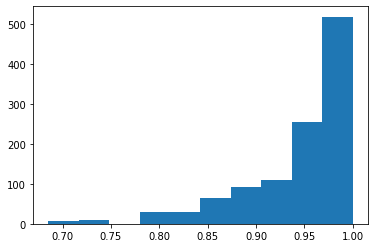

In [66]:
sents, posids = create_inputs(processedgraphs[0:0+1])
out = latbert(sents, posids)
latembed = out['last_hidden_state'][0]
plt.hist(get_diff_base(latembed, sents[0]))

In [96]:
res = []

get_ex_notbase(0, 5)


[0.4216383578272023]

In [ ]:
plt.hist(res, bins = 2)

In [35]:
res[9]

[0.719793975353241,
 0.7008659243583679,
 0.6701750755310059,
 0.6903993487358093,
 0.6903993487358093]

In [29]:
print(norm_inputs)
print(sents)

tensor([[ 101,  146, 1341, 1175, 1132, 1160, 3001, 1104, 2593, 1113, 1103, 1226,
         1104, 1103, 1497, 2384,  112,  188, 2593,  119,  102]])
tensor([[ 101,  146, 1341, 1175, 1132, 1160, 3001, 1104, 2593, 1118, 1103, 1497,
         2384,  119,  119, 1113, 1103, 1226, 1104, 1103, 1497, 2384,  119,  112,
          188, 2593,  119, 1121, 1103, 1497, 2384, 2059, 1175, 1132, 1160, 1115,
         1175, 1132, 1160, 3001, 1104, 2593, 1118, 1103, 1497, 2384,  119,  119,
         1113, 1103, 1226, 1104, 1103, 1497, 2384,  119, 1121, 1103, 1497, 2384,
         1130, 1139, 2458, 1175, 1132, 1160,  117, 1103, 1497, 2384, 1144, 5133,
         1120, 1160, 3001,  119, 1160, 3001,  119, 1104, 2593, 1106, 1142, 1121,
         1103, 2827,  119, 1118, 1103, 1497, 2384,  119,  119, 1113, 1103, 1497,
         2384,  119,  787,  188, 1226,  119,  112,  188, 1226,  119, 1226, 1104,
         1103, 2384,  119, 1104, 1699,  119, 1497, 3912,  119, 2384,  131,  119,
         1121, 1103, 2384,  119, 1104, 1699,

In [16]:
word_list = list(set(" ".join(sentences).split()))

In [11]:
# adding special tokens
word_dict = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3}

# create vocabulary dictionaries (word->token id mapping)
for i, w in enumerate(word_list):
    word_dict[w] = i + 4
    number_dict = {i: w for i, w in enumerate(word_dict)}
    vocab_size = len(word_dict)

In [14]:
def make_batch():
    batch = []
    positive = negative = 0
    
    # keep things balanced? 
    while positive != batch_size/2 or negative != batch_size/2:
        # get 2 random sentences, we want to check if they're contiguous or not
        tokens_a_index, tokens_b_index = randrange(len(sentences)), randrange(len(sentences)) 
        
        # not sure where token_list comes from 
        tokens_a, tokens_b = token_list[tokens_a_index], token_list[tokens_b_index]

        # create a list with all the appropriate token ids for the input formatting
        input_ids = [word_dict['[CLS]']] + tokens_a + [word_dict['[SEP]']] + tokens_b + [word_dict['[SEP]']]

        # handle segment embedding?
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        # MASK LM
        # get num of tokens to mask
        n_pred =  min(max_pred, max(1, int(round(len(input_ids) * 0.15)))) # 15 % of tokens in one sentence
        cand_maked_pos = [i for i, token in enumerate(input_ids)
                         if token != word_dict['[CLS]'] and token != word_dict['[SEP]']]
        shuffle(cand_maked_pos)
        
        # randomly select 15% of tokens to mask
        masked_tokens, masked_pos = [], []
        for pos in cand_maked_pos[:n_pred]:
            
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            # usually just mask
            if random() < 0.8:  # 80%
                input_ids[pos] = word_dict['[MASK]'] # make mask
            # sometimes just put a random word in
            elif random() < 0.5:  # 10%
                index = randint(0, vocab_size - 1) # random index in vocabulary
                input_ids[pos] = word_dict[number_dict[index]] # replace

        # Zero Paddings
        n_pad = maxlen - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # Zero Padding (100% - 15%) tokens
        if max_pred > n_pred:
            n_pad = max_pred - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        if tokens_a_index + 1 == tokens_b_index and positive < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True]) # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size/2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False]) # NotNext
            negative += 1
    return batch

In [23]:
# print(torch.arange(30, dtype=torch.long).expand_as(input_ids))
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(maxlen, d_model)  # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, seg):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

In [24]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

In [ ]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.embedding = Embedding()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ1 = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.activ2 = gelu
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        # it will be decided by first token(CLS)
        h_pooled = self.activ1(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_clsf = self.classifier(h_pooled) # [batch_size, 2]

        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]

        # get masked position from final output of transformer.
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked = self.norm(self.activ2(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_clsf

In [1]:

examples = ["Barack Obama receives Iraq’s prime minister in the midst of escalating violence."]

In [2]:
# Importing the relevant modules
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch

device = "cuda:2"
# Loading the pre-trained BERT model
###################################
# Embeddings will be derived from
# the outputs of this model
model = BertModel.from_pretrained('bert-base-cased',
           output_hidden_states = True,).to(device)
# Setting up the tokenizer
###################################
# This is the same tokenizer that
# was used in the model to generate
# embeddings to ensure consistency
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

2022-08-15 07:46:29.695833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-15 07:46:29.695855: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mo

In [10]:
def bert_text_preparation(text, tokenizer):
    """Preparing the input for BERT
    
    Takes a string argument and performs
    pre-processing like adding special tokens,
    tokenization, tokens to ids, and tokens to
    segment ids. All tokens are mapped to seg-
    ment id = 1.
    
    Args:
        text (str): Text to be converted
        tokenizer (obj): Tokenizer object
            to convert text into BERT-re-
            adable tokens and ids
        
    Returns:
        list: List of BERT-readable tokens
        obj: Torch tensor with token ids
        obj: Torch tensor segment ids
    
    
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens]).to(device)
    segments_tensors = torch.tensor([segments_ids]).to(device)

    return tokenized_text, tokens_tensor, segments_tensors

def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Get embeddings from an embedding model
    
    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids
    
    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token
    
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings


In [13]:
target_word_embeddings = []

for text in examples:
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    
    # Find the position 'bank' in list of tokens
    word_index = tokenized_text.index('Obama')
    # Get the embedding for bank
    word_embedding = list_token_embeddings[word_index]

    target_word_embeddings.append(word_embedding)

In [17]:
len(target_word_embeddings[0])

768

In [107]:
bert_model = LinearLatticeBert(52)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [119]:
sents = torch.tensor(sents).to(device)
posids = torch.tensor(posids).to(device)

In [120]:
out = bert_model(sents, posids)

In [126]:

lhs = out['last_hidden_state'][0]

In [139]:
list(sents[0])[14]

tensor(119, device='cuda:2')

In [155]:
ind_cos_dist(13, 14, lhs)

1.0

In [171]:
inptest = bert_tok(clean_expanded(resarrs[0][1]))

In [169]:
normal_bert = AutoModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [180]:
normalout = normal_bert(torch.tensor([inptest.input_ids]),return_dict=True, output_hidden_states=True)
normalhs = normalout['last_hidden_state'][0]

In [175]:
bert_tok(clean_expanded(resarrs[0][1]))

{'input_ids': [101, 1109, 27020, 1692, 1223, 10443, 1103, 2335, 2960, 1104, 6145, 1113, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [183]:
tok_cos_dist(lhs,normalhs,  1109)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous